## Climate Change Belief Analysis
### By Team_JS_2_EDSA

# 1: Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

This predict layout as follows:

    1. Introduction
    2. Import libraries and load data
    3. Data pre-processing
    4. Exploratory Data Analysis
    5. Building models
    6. Best model
    7. Conclusion
    8. Submission

# 2: Import libraries and load data

In [1]:
from comet_ml import Experiment

In [120]:
# Run to allow Comet to log the parameters of the models and output of cells.
experiment = Experiment(api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
                        project_name="classification-predict",
                        workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/classification-predict/3c872cad52b846d0977d9d93ef2bcb52



In [266]:
# Standard
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Natural language Processing
import nltk
import string
import re
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier

# Performance
from sklearn.metrics import f1_score
from sklearn import metrics

# Saving
import pickle


## The data

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018!

In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes: 2, 1, 0, -1

**Class Description:**

- 2 News: the tweet links to factual news about climate change

- 1 Pro: the tweet supports the belief of man-made climate change

- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

- -1 Anti: the tweet does not believe in man-made climate change Variable definitions

**Columns:**

- sentiment: Sentiment of tweet

- message: Tweet body

- tweetid: Twitter unique id

In [4]:
#Loading data and view first few rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test_with_no_labels.csv")

In [5]:
train

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
...,...,...,...
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732


In [6]:
test

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
...,...,...
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714
10542,2016: the year climate change came home: Durin...,875167
10543,RT @loop_vanuatu: Pacific countries positive a...,78329
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455


# 3: Preprocessing

## 3.1 - Let's do some data cleaning

Function for cleaning the data:

* Remove punctuations 
* Remove stop words
* Lemmitazation 

In [7]:
#Cleaning all tweets by removing url-links, punctuation, digits, stopwords and Lemmatizing all the words.
def clean_tweets(message):

    # change all words into lower case
    message = message.lower()

    # replace all url-links with url-web
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    web = 'url-web'
    message = re.sub(url, web, message)

    # removing all punctuation and digits
    message = re.sub(r'[-]',' ',message)
    message = re.sub(r'[^\w\s]','',message)
    message = re.sub('[0-9]+', '', message)

    message = re.sub("â|ã", " ", message)  # removes strange character    
    message = re.sub("\\s+", " ", message)  # fills white spaces
    message = message.lstrip()  # removes whitespaces before string
    message = message.rstrip()  # removes whitespaces after string 
    
    # lemmatizing all words
    message = message.lower()
    lemmatizer = WordNetLemmatizer()
    message = [lemmatizer.lemmatize(token) for token in message.split(" ")]
    message = [lemmatizer.lemmatize(token, "v") for token in message]
    message = " ".join(message)

    return message

In [8]:
%%time
#Apply the clean function to our train and test data
train['message_clean']=train['message'].apply(clean_tweets)

test['message_clean']=test['message'].apply(clean_tweets)

In [9]:
#Data after clean: Train
train.head()

,sentiment,message,tweetid,message_clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say we have three year ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire wa a pivotal year in the war...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas it and a racist sexist clim...


In [10]:
#Data after clean: Test
test.head()

,message,tweetid,message_clean
0,Europe will now be looking to China to make su...,169760,europe will now be look to china to make sure ...
1,Combine this with the polling of staffers re c...,35326,combine this with the poll of staffer re clima...
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin get ...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...


## 3.2 - Let's see if there is a imbalance in the data

In [9]:
#Count of data entries for different sentiments
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

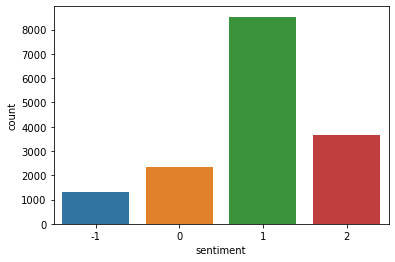

In [10]:
#View class distribution to confirm balance/imbalance
sns.countplot(train['sentiment'])

## Balancing the data

There is a different ways of balancing data:

- 1: Resampling
- 2: SMOTE

In [248]:
#Applying each sentiment to their own data frame
news = train[train['sentiment'] == 2]
pro = train[train['sentiment'] == 1]
neutral = train[train['sentiment'] == 0]
anti = train[train['sentiment'] == -1]

In [249]:
#Applying the resampling method to the data
news_upsampled = resample(news, replace=True, n_samples=len(pro), random_state=27)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(pro), random_state=27)
anti_upsampled = resample(anti, replace=True, n_samples=len(pro), random_state=27)

**Combine majority and new upsampled minority**

In [250]:
#New upsampled train dataframe
df_upsampled = pd.concat([pro, news_upsampled, neutral_upsampled, anti_upsampled])

In [251]:
df_upsampled.sentiment.value_counts()

 0    8530
 1    8530
 2    8530
-1    8530
Name: sentiment, dtype: int64

C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

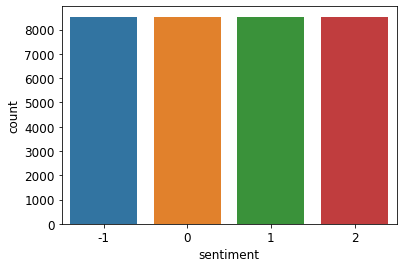

In [265]:
sns.countplot(df_upsampled['sentiment'])

In [16]:
df_upsampled

,sentiment,message,tweetid,message_clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire wa a pivotal year in the war...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas it and a racist sexist clim...
5,1,Worth a read whether you do or don't believe i...,425577,worth a read whether you do or dont believe in...
...,...,...,...,...
5422,-1,RT @worldnetdaily: Sorry global warming liars....,857394,rt worldnetdaily sorry global warm liar arctic...
11148,-1,RT @charlesadler: #Trudeau gov now admitting l...,509562,rt charlesadler trudeau gov now admit long ter...
11428,-1,That would be a natural storm and of course po...,158073,that would be a natural storm and of course po...
1341,-1,RT @TheFoundingSon: NOAA scientists manipulate...,905959,rt thefoundingson noaa scientist manipulate te...


# 4: Exploratory Data Analysis

- Make use of seaborn, wordcloud and matplotlib

## 4.1: Extract Hashtags

## 4.2: Extract Frequently used words

## 4.3: Named entity extraction 

## 4.4: Create graphs

# 5: Modeling

Here we can decide to use one of two dataframes:

- 1: Normal clean train dataframe(train)
- 2: Balanced clean train dataframe(df_upsampled)

In [68]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

### Turning text into something your model can read, we will make use of Pipeline package to vectorize and run our models

Models:
- 1: Linear Support Vector Classifier
- 2: ......
- 3: ......
- 4: .....


In [69]:
classifiers = [
               LinearSVC(random_state=42),
               ExtraTreesClassifier(),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               MultinomialNB(),
               RidgeClassifier(),
               RandomForestClassifier()
    ]


In [70]:
#Function to fit/test classifiers and return a performance summary                                             
def model_assessment(classifiers, X_train, y_train, X_test,y_test):
    
    model_summary = {}
    
    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])

    # Execution Time Logging
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        run_time = time.time()-start_time
      
    # Models Performance
        model_summary[clf.__class__.__name__] = {
          'F1-Macro':metrics.f1_score(y_test,predictions,average='macro'),
          'F1-Accuracy':metrics.f1_score(y_test,predictions,average='micro'),
          'F1-Weighted':metrics.f1_score(y_test,predictions,average='weighted'),
          'Execution Time': run_time }
      
        
    return pd.DataFrame.from_dict(model_summary, orient='index')

In [71]:
%%time
clf_performance_df = model_assessment(classifiers,X_train, y_train, X_test, y_test)
ordered_clf_performance_df = clf_performance_df.sort_values('F1-Weighted',ascending=False)
ordered_clf_performance_df

COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Wall time: 2min 28s


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.706003,0.786346,0.773145,1.335453
RidgeClassifier,0.686667,0.774968,0.758995,1.202842
SGDClassifier,0.670172,0.769912,0.751909,1.241481
LogisticRegression,0.649375,0.756005,0.738006,15.827552
ExtraTreesClassifier,0.628157,0.734513,0.717859,79.136315
RandomForestClassifier,0.603440,0.705436,0.694623,43.302055
KNeighborsClassifier,0.605026,0.672566,0.668443,1.407305
AdaBoostClassifier,0.503308,0.639697,0.608199,4.191424
MultinomialNB,0.388446,0.658660,0.573410,0.827890


<AxesSubplot:>

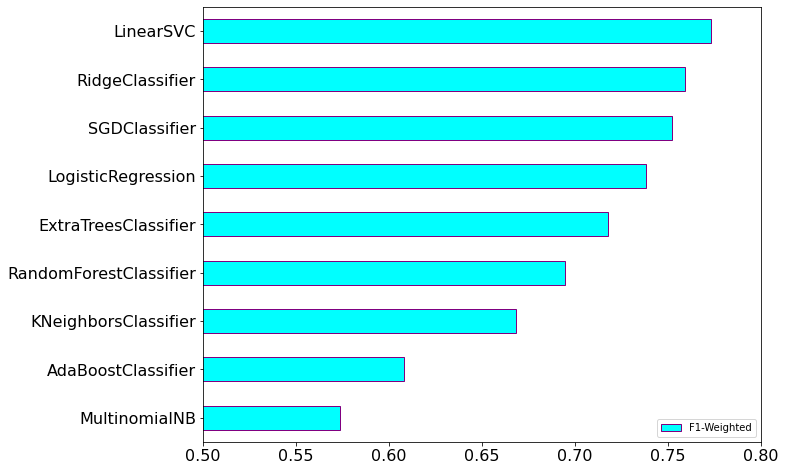

In [244]:
# Plot the results
ordered_clf_performance_df.sort_values('F1-Weighted',ascending=True).plot(y='F1-Weighted', 
                                                            kind='barh', 
                                                            xlim=[0.5, 0.8], 
                                                            color= 'cyan', 
                                                            edgecolor = 'purple',
                                                            figsize=(10, 8), 
                                                            fontsize=16)


In [27]:
#Function to fit/test classifiers and return a performance summary                                             
def model_assessment_CV(X,y):
    
    model_summary = []
    
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])

    # Execution Time Logging
        start_time = time.time()
        scores = cross_val_score(model, X=X, y=y, cv=5)
        run_time = time.time()-start_time
        model_summary.append([clf.__class__.__name__, scores.mean(), scores.std(), run_time])
    
    performace_summary = pd.DataFrame(model_summary, columns=['Model', 'CV_Mean', 'CV_Std','Execution Time'])
    performace_summary.set_index('Model', inplace=True)
 
    return performace_summary

In [28]:
%%time
CV_clf_performance_df = model_assessment_CV(X,y)

In [61]:
ordered_CV_clf_performance_df = CV_clf_performance_df.sort_values('CV_Mean',ascending=False)

In [62]:
# Save the results so we dont have to run it again
ordered_CV_clf_performance_df.to_csv('ordered_CV_clf_performance_df.csv')

In [202]:
ordered_CV_clf_performance_df = pd.read_csv('ordered_CV_clf_performance_df.csv', index_col = 'Model')
ordered_CV_clf_performance_df

,CV_Mean,CV_Std,Execution Time
Model,,,
LinearSVC,0.753904,0.007763,5.458754
RidgeClassifier,0.749985,0.008328,9.932733
SGDClassifier,0.744675,0.007363,9.578883
LogisticRegression,0.728744,0.008132,78.864897
ExtraTreesClassifier,0.722612,0.008042,280.153271
RandomForestClassifier,0.697074,0.008338,290.783042
KNeighborsClassifier,0.643783,0.005295,24.445339
MultinomialNB,0.638283,0.003658,7.435782
AdaBoostClassifier,0.630192,0.008455,34.111243


<AxesSubplot:ylabel='Model'>

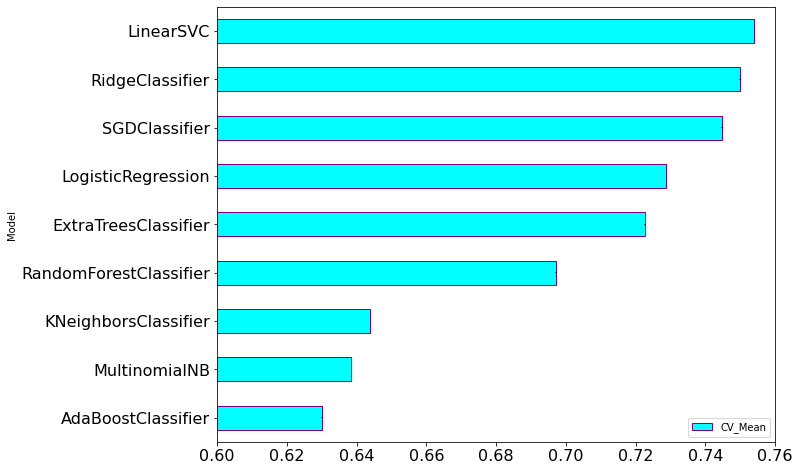

In [245]:
# Plot the results
ordered_CV_clf_performance_df.sort_values('CV_Mean',ascending=True).plot(y='CV_Mean', \
                                                                yerr='CV_Std', 
                                                                kind='barh', 
                                                                xlim=[0.6, 0.76],
                                                                color= 'cyan', 
                                                                edgecolor = 'purple',        
                                                                figsize=(10, 8), 
                                                                fontsize=16)

# 5.1: Hyperparameter Tuning


Let's tune the hyperparameters of our 4 best models to improve their ability to classify the tweets. 

In [26]:
classifiers = [
               LinearSVC(random_state=42),
               LogisticRegression(random_state=42, n_jobs=1, max_iter=5000),
               SGDClassifier(),
               RidgeClassifier()
    ]

First, let's define a function to see what their current hyperparameters are.

In [27]:
def get_hyperparams(classifiers, X_train, y_train):
    
    model_params = {}
  
    for clf in classifiers:
        model = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))),
                    ('clf',clf)
                          ])
        
        model.fit(X_train, y_train)
        
        params = model.get_params()
        model_name = clf.__class__.__name__ 
        model_name = {}
        
        for key in params:
            if key.startswith("clf"):
                if len(key) < 5:
                    model_name['model'] = params[key]
                else:
                    model_name[key[5:]] = params[key]
        
        model_params[clf.__class__.__name__] = model_name
        
    return model_params

In [17]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [18]:
%%time
model_params = get_hyperparams(classifiers, X_train, y_train)

In [19]:
model_params[classifiers[0].__class__.__name__]  # classifiers[0] == LinearSVC

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

##  Grid Search CV

We'll use GridSearchCV to tune the hyperparamerts of our models.

In [108]:
# Prep the data

X = train['message_clean']
y = train['sentiment'] 

vect = TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))
X_vectorized = vect.fit_transform(X)

X_train , X_test , y_train , y_test = train_test_split(X_vectorized, y, test_size=0.05, random_state =42)

### Ridge Classifier

In [166]:
#Current Hyperparameters
model_params[classifiers[3].__class__.__name__]

{'model': RidgeClassifier(),
 'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [61]:
%%time
# define model and params

model = RidgeClassifier()
alpha = list(np.linspace(0.17,0.24,8))
class_weight = [None]


grid = dict(alpha=alpha, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)

ridge = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')

experiment.log_dataset_hash(X_train)
experiment.log_parameters({"model_type": "Ridge Classifier", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1min 46s


In [62]:
print(ridge.best_score_)
print(ridge.best_params_) 
print(ridge.best_estimator_) 

0.7445604265377659
{'alpha': 0.24, 'class_weight': None}
RidgeClassifier(alpha=0.24)


### Logistic Regression

In [177]:
#Current Hyperparameters
model_params[classifiers[1].__class__.__name__]

{'model': LogisticRegression(max_iter=5000, n_jobs=1, random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
%%time
# !!! dont run this cell, takes 1hr22m to execute

# define model and params

model = LogisticRegression()

c_values = [150, 100, 10, 1.0, 0.5]
penalty = ['l2']
solvers = ['lbfgs']
max_iter = [6000, 5000]

grid = dict(solver=solvers, penalty=penalty, C=c_values, max_iter=max_iter)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
logistic = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 1h 22min 47s


In [65]:
print(logistic.best_score_)
print(logistic.best_params_) 
print(logistic.best_estimator_) 

0.7445436868541936
{'C': 100, 'max_iter': 6000, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression(C=100, max_iter=6000)


In [67]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58        61
           0       0.69      0.39      0.50       123
           1       0.78      0.91      0.84       441
           2       0.82      0.83      0.82       166

    accuracy                           0.78       791
   macro avg       0.76      0.65      0.68       791
weighted avg       0.77      0.78      0.76       791

0.7619583543886658


### Stochastic Gradient Descent Classifier

In [185]:
#Current Hyperparameters
model_params[classifiers[2].__class__.__name__]

{'model': SGDClassifier(),
 'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [88]:
%%time
# define model and params
model = SGDClassifier()
alpha = [0.00002, 0.000015, 0.000017, 0.000018]
power_t = [0.32, 0.3, 0.28]
penalty = ['l2']
max_iter = [6000]

# define grid search
grid = dict(penalty=penalty, alpha=alpha, max_iter=max_iter, power_t=power_t)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
sgd = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 39.7 s


In [89]:
print(sgd.best_score_)
print(sgd.best_params_) 
print(sgd.best_estimator_) 

0.7472554292373719
{'alpha': 2e-05, 'max_iter': 6000, 'penalty': 'l2', 'power_t': 0.32}
SGDClassifier(alpha=2e-05, max_iter=6000, power_t=0.32)


In [90]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.75      0.49      0.59        61
           0       0.66      0.41      0.51       123
           1       0.79      0.90      0.84       441
           2       0.81      0.86      0.83       166

    accuracy                           0.78       791
   macro avg       0.75      0.66      0.69       791
weighted avg       0.77      0.78      0.77       791

0.7696406834673507


### Linear SVC 

In [186]:
#Current Hyperparameters
model_params[classifiers[0].__class__.__name__]

{'model': LinearSVC(random_state=42),
 'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [115]:
%%time
# define model and params

model = LinearSVC()
C = [1, 1.3]
max_iter = [1000]
class_weight = ['balanced', None]

grid = dict(C=C, max_iter=max_iter, class_weight=class_weight)

cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=1)
lsvc = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')


experiment.log_parameters({"model_type": "Logistic Regression", "param_grid": grid})
experiment.log_metrics({'F1 Macro': f1_macro, "Accuracy": f1_weighted})

Wall time: 51 s


In [116]:
print(lsvc.best_score_)
print(lsvc.best_params_) 
print(lsvc.best_estimator_) 

0.7511315295394302
{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
LinearSVC(C=1, class_weight='balanced')


In [117]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

          -1       0.72      0.56      0.63        61
           0       0.64      0.47      0.54       123
           1       0.82      0.86      0.84       441
           2       0.78      0.87      0.82       166

    accuracy                           0.78       791
   macro avg       0.74      0.69      0.71       791
weighted avg       0.77      0.78      0.77       791

0.7724148569820287


In [119]:
experiment.end()

# 5.2: Model Assessment

Let's train our newly tuned models and assess their accuracy.

In [121]:
X = train['message_clean']
y = train['sentiment'] 
X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [127]:
best_classifiers = [ 
                     LinearSVC(C = 1, max_iter= 1000),
                     LogisticRegression(C= 100, max_iter= 6000, penalty= 'l2', solver= 'lbfgs', n_jobs=1),
                     SGDClassifier(alpha=2e-05, max_iter= 6000, penalty='l2', power_t= 0.32),
                     RidgeClassifier(alpha=0.24)
    ]

In [128]:
%%time
best_performing_df = model_assessment(best_classifiers,X_train, y_train, X_test, y_test)
ordered_best_performing_df = best_performing_df.sort_values('F1-Weighted',ascending=False)
ordered_best_performing_df

Wall time: 55.7 s


,F1-Macro,F1-Accuracy,F1-Weighted,Execution Time
LinearSVC,0.706003,0.786346,0.773145,1.332275
LogisticRegression,0.703153,0.781290,0.770756,51.758541
RidgeClassifier,0.698101,0.780025,0.766939,1.453779
SGDClassifier,0.696902,0.776233,0.764144,1.077737


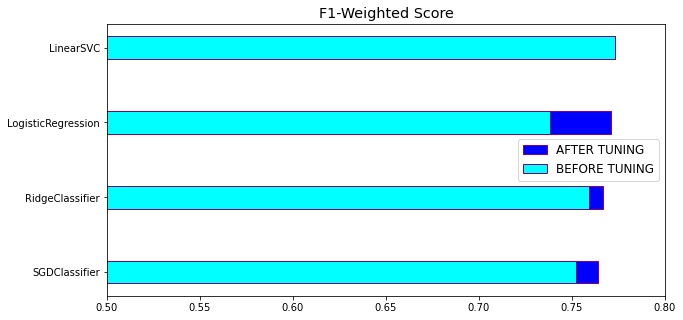

In [246]:
# The results
after = ordered_best_performing_df.sort_values('F1-Weighted',ascending=True)
before = ordered_clf_performance_df.sort_values('F1-Weighted',ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim([0.5, 0.8])
plt.rcParams['font.size'] = '12'

hyperparams_2 = after['F1-Weighted'].index
hyperparams_1 = before['F1-Weighted'].index
f12 = after['F1-Weighted']
f11 = before['F1-Weighted'][hyperparams_2]

after_tuning = ax.barh(y= hyperparams_2, width= f12, height =0.3, color= 'blue', 
                                   edgecolor = 'purple',label = 'AFTER TUNING')
before_tuning = ax.barh(y=hyperparams_2, width= f11, height =0.3, color= 'cyan', 
                        edgecolor = 'purple', label = 'BEFORE TUNING')
ax.set_title('F1-Weighted Score')

ax.legend()
plt.show()

...something about the performance of the models

## 5.3: Best Model

In [97]:
X = train['message_clean']
y = train['sentiment'] 

X_train , X_test , y_train , y_test = train_test_split(X , y, test_size =0.05, random_state =42)

In [98]:
%%time
#Pipeline to for vect and training
Model_1_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(stop_words='english',  min_df=1, max_df=0.9, ngram_range=(1, 2))), 
                        ('classification', LinearSVC()) 
                        ])

#Fitting our Linear SVC model
Model_1_pipe.fit(X_train, y_train)


Wall time: 1.54 s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classification', LinearSVC())])

### After fitting our model now we predict and evaluate our model

In [100]:
#Prediting our findings of our model and see how accurate it is.
y_pred_lsvc = Model_1_pipe.predict(X_test)

In [102]:
print("Model: Linear SVC Metrics")
print(metrics.f1_score(y_test, y_pred_lsvc, average='weighted'))

Model: Linear SVC Metrics
0.7731445060771621


### As we can see our model predicts very accurate on our train test and split data with a +95%, now we will go and use the model on our unseen test data

# 6: Use best model on our test/real word data

In [ ]:
#Using our pipeline best model to predict our findings
test['sentiment'] = Main_final.predict(test['message_clean'])

In [ ]:
#Viewing our new data for sentiment in test dataframe
test.head()

# 7: Conclusion

# 8: Submission
 Creating an output csv for submission

In [26]:
#Submission in our kaggle format
submission = test[['tweetid', 'sentiment']]
submission.to_csv('LSVC.csv',index=False)